In [1]:
from google.colab import files

uploaded = files.upload()   # choose scandi_chapter1_snapshot.zip from your machine


Saving scandi_chapter1_snapshot.zip to scandi_chapter1_snapshot.zip


In [2]:
!unzip scandi_chapter1_snapshot.zip -d /content


Archive:  scandi_chapter1_snapshot.zip
   creating: /content/content/scandi_betting/
  inflating: /content/content/scandi_betting/scandi.db  


In [3]:
!mv /content/content/scandi_betting /content/scandi_betting
!rm -r /content/content  # optional clean-up


In [4]:
import sqlite3
import pandas as pd

db_path = "/content/scandi_betting/scandi.db"

conn = sqlite3.connect(db_path)
df_clean = pd.read_sql_query("SELECT * FROM clean_matches;", conn)
conn.close()

df_clean.head()


,id,source,league,season_year,match_date,home_team,away_team,home_goals,away_goals,odds_ft_1,...,odds_btts_no,ingested_at,has_1x2,has_over25,has_btts,core_markets_ready,result_1x2,total_goals,btts_outcome,ou25_outcome
0,1,footystats_csv,Eliteserien,2025,Mar 29 2025 - 3:00pm,Strømsgodset,Rosenborg,1,2,3.27,...,2.35,2025-12-09T22:08:24,1,1,1,1,A,3,1,1
1,2,footystats_csv,Eliteserien,2025,Mar 29 2025 - 5:00pm,Fredrikstad,Brann,3,0,3.55,...,1.83,2025-12-09T22:08:24,1,1,1,1,H,3,0,1
2,3,footystats_csv,Eliteserien,2025,Mar 30 2025 - 12:30pm,Vålerenga,Viking,3,1,2.30,...,2.40,2025-12-09T22:08:24,1,1,1,1,H,4,1,1
3,4,footystats_csv,Eliteserien,2025,Mar 30 2025 - 3:00pm,Molde,Sarpsborg 08,0,2,1.47,...,2.12,2025-12-09T22:08:24,1,1,1,1,A,2,0,0
4,5,footystats_csv,Eliteserien,2025,Mar 30 2025 - 3:00pm,KFUM,Sandefjord,3,1,2.25,...,1.78,2025-12-09T22:08:24,1,1,1,1,H,4,1,1


In [5]:
import numpy as np

mask_no_2025 = (
    (df_clean["league"] == "Eliteserien") &
    (df_clean["season_year"] == 2025) &
    (df_clean["odds_ft_1"].notna()) &
    (df_clean["odds_ft_x"].notna()) &
    (df_clean["odds_ft_2"].notna()) &
    (df_clean["odds_ft_1"] > 1.0) &
    (df_clean["odds_ft_x"] > 1.0) &
    (df_clean["odds_ft_2"] > 1.0)
)

df_no_2025 = df_clean[mask_no_2025].copy()

# recompute implied probs & overround
df_no_2025["pH_raw"] = 1.0 / df_no_2025["odds_ft_1"]
df_no_2025["pD_raw"] = 1.0 / df_no_2025["odds_ft_x"]
df_no_2025["pA_raw"] = 1.0 / df_no_2025["odds_ft_2"]
df_no_2025["sum_raw"] = df_no_2025["pH_raw"] + df_no_2025["pD_raw"] + df_no_2025["pA_raw"]
df_no_2025["overround"] = df_no_2025["sum_raw"] - 1.0


In [6]:
df_calib = df_no_2025.copy()
df_calib["pH"] = df_calib["pH_raw"] / df_calib["sum_raw"]
df_calib["pD"] = df_calib["pD_raw"] / df_calib["sum_raw"]
df_calib["pA"] = df_calib["pA_raw"] / df_calib["sum_raw"]
df_calib["home_win"] = np.where(df_calib["result_1x2"] == "H", 1, 0)


In [7]:
bin_edges = np.linspace(0.0, 1.0, 11)
df_calib["pH_bin"] = pd.cut(df_calib["pH"], bins=bin_edges, include_lowest=True, right=True)

calib_home = (
    df_calib.groupby("pH_bin", observed=True)
    .agg(
        n=("home_win", "size"),
        pred_mean=("pH", "mean"),
        obs_rate=("home_win", "mean")
    )
    .reset_index()
)

calib_home = calib_home[calib_home["n"] >= 5].copy()
calib_home["bin_low"] = calib_home["pH_bin"].apply(lambda x: x.left)
calib_home["bin_high"] = calib_home["pH_bin"].apply(lambda x: x.right)

# find the bin with biggest mismatch (we'll highlight it)
calib_home["diff"] = calib_home["obs_rate"] - calib_home["pred_mean"]
idx_max_diff = calib_home["diff"].abs().idxmax()
highlight_row = calib_home.loc[idx_max_diff]


In [8]:
import matplotlib.pyplot as plt

# ---------- COLOURS ----------
GREY_BG     = "#E5E5E5"   # light grey plot background
GREY_GRID   = "#CCCCCC"
BLACK       = "#000000"
WHITE       = "#FFFFFF"
NEON_YELLOW = "#FFE81F"   # highlight colour


# ---------- STYLE HELPERS ----------
def style_light_axes(ax, bg=GREY_BG, text=BLACK, grid_color=GREY_GRID):
    """
    Light theme: grey background, black text.
    Use this for charts that sit on a grey page.
    """
    ax.set_facecolor(bg)
    # axis labels & title
    ax.xaxis.label.set_color(text)
    ax.yaxis.label.set_color(text)
    ax.title.set_color(text)
    # ticks
    ax.tick_params(axis="x", colors=text)
    ax.tick_params(axis="y", colors=text)
    # spines
    for spine in ax.spines.values():
        spine.set_edgecolor(text)
    # grid
    ax.grid(True, alpha=0.5, color=grid_color)


def style_dark_axes(ax, bg=BLACK, text=WHITE, grid_color=GREY_GRID):
    """
    Dark theme: black background, white text.
    Use this if you ever want a chart or inset on black.
    """
    ax.set_facecolor(bg)
    ax.xaxis.label.set_color(text)
    ax.yaxis.label.set_color(text)
    ax.title.set_color(text)
    ax.tick_params(axis="x", colors=text)
    ax.tick_params(axis="y", colors=text)
    for spine in ax.spines.values():
        spine.set_edgecolor(text)
    ax.grid(True, alpha=0.5, color=grid_color)


def set_fig_bg(fig, color):
    fig.patch.set_facecolor(color)


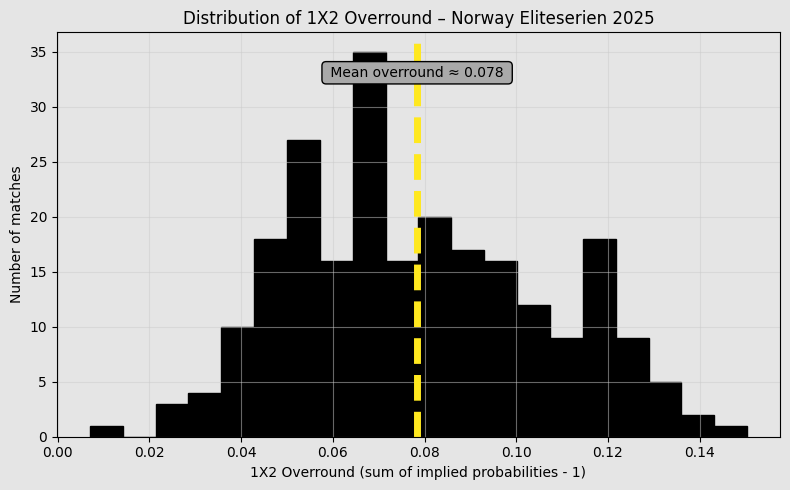

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

# Grey figure background
set_fig_bg(fig, GREY_BG)

# Histogram in black
ax.hist(
    df_no_2025["overround"],
    bins=20,
    color=BLACK,
    edgecolor=BLACK
)

# Mean overround
mean_overround = df_no_2025["overround"].mean()

# Neon yellow mean line
ax.axvline(
    mean_overround,
    color=NEON_YELLOW,
    linestyle="--",
    linewidth=5
)

ax.set_title("Distribution of 1X2 Overround – Norway Eliteserien 2025")
ax.set_xlabel("1X2 Overround (sum of implied probabilities - 1)")
ax.set_ylabel("Number of matches")

# Apply light style: grey bg + black text
style_light_axes(ax)

# Black box with white text pointing at the mean
ax.text(
    mean_overround,
    ax.get_ylim()[1] * 0.9,
    f" Mean overround ≈ {mean_overround:.3f} ",
    color=BLACK,  # text colour (Black)
    ha="center",
    va="center",
    bbox=dict(
        facecolor="#A9A9A9",   # Dark Grey box
        edgecolor=BLACK,   # thin black border
        boxstyle="round,pad=0.3",
        alpha=1.0
    )
)

plt.tight_layout()
plt.show()


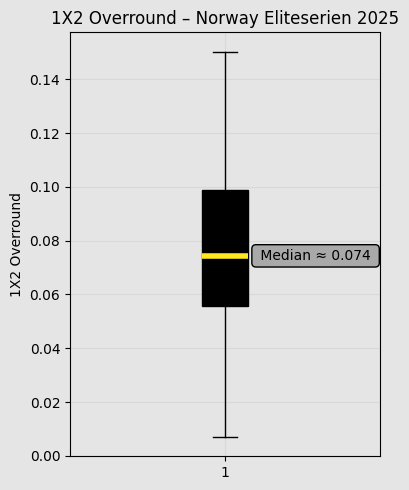

In [15]:
fig, ax = plt.subplots(figsize=(4, 5))

set_fig_bg(fig, GREY_BG)

box = ax.boxplot(
    df_no_2025["overround"],
    vert=True,
    patch_artist=True
)

# Box & whiskers: black on grey
for patch in box["boxes"]:
    patch.set_facecolor(BLACK)
    patch.set_edgecolor(BLACK)

for whisker in box["whiskers"]:
    whisker.set_color(BLACK)

for cap in box["caps"]:
    cap.set_color(BLACK)

# Median highlighted in neon yellow
for median in box["medians"]:
    median.set_color(NEON_YELLOW)
    median.set_linewidth(4)

ax.set_ylabel("1X2 Overround")
ax.set_title("1X2 Overround – Norway Eliteserien 2025")

style_light_axes(ax)

# Black box with white text for median
median_val = df_no_2025["overround"].median()
ax.text(
    1.1,                         # a bit to the right of the box
    median_val,
    f" Median ≈ {median_val:.3f} ",
    color=BLACK,
    ha="left",
    va="center",
    bbox=dict(
        facecolor="#A9A9A9",
        edgecolor=BLACK,
        boxstyle="round,pad=0.3",
        alpha=1.0
    )
)

plt.tight_layout()
plt.show()


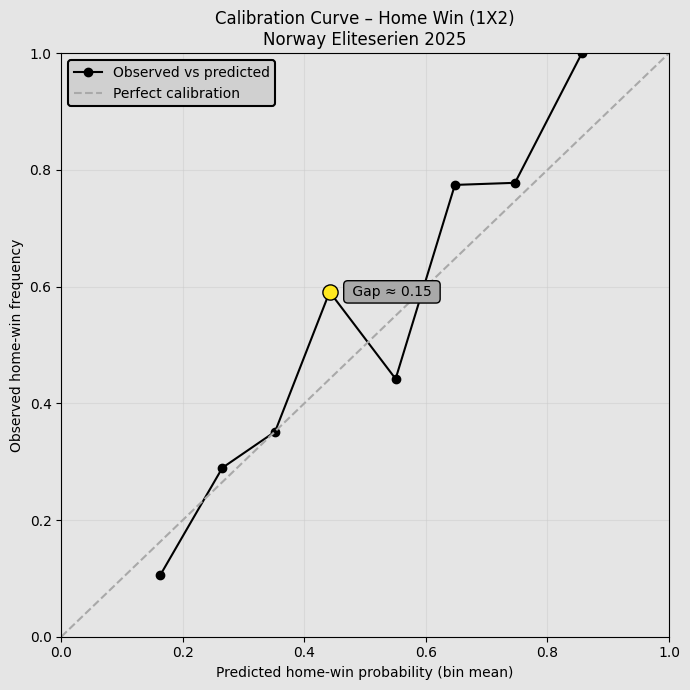

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))

set_fig_bg(fig, GREY_BG)

# Main calibration line
ax.plot(
    calib_home["pred_mean"],
    calib_home["obs_rate"],
    marker="o",
    linestyle="-",
    color=BLACK,
    label="Observed vs predicted"
)

# Perfect calibration line
ax.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    color="#A9A9A9",
    label="Perfect calibration"
)

# Neon highlight: largest deviation bin
ax.scatter(
    highlight_row["pred_mean"],
    highlight_row["obs_rate"],
    color=NEON_YELLOW,
    edgecolor=BLACK,
    s=120,
    zorder=5
)

ax.set_xlabel("Predicted home-win probability (bin mean)")
ax.set_ylabel("Observed home-win frequency")
ax.set_title("Calibration Curve – Home Win (1X2)\nNorway Eliteserien 2025")

ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)

style_light_axes(ax)

# ---- Legend styling ----
LEGEND_BG = "#D0D0D0"   # slightly darker grey than main BG (#E5E5E5)

legend = ax.legend(frameon=True)

# Frame (box) style
frame = legend.get_frame()
frame.set_facecolor(LEGEND_BG)   # grey background for the legend box
frame.set_edgecolor(BLACK)       # black border
frame.set_linewidth(1.5)         # a bit thicker border
frame.set_alpha(1.0)             # no transparency

# Legend text colour
for text in legend.get_texts():
    text.set_color(BLACK)


# Black box annotation near highlighted bin
ax.text(
    highlight_row["pred_mean"] + 0.03,
    highlight_row["obs_rate"],
    f" Gap ≈ {highlight_row['diff']:.2f} ",
    color=BLACK,
    ha="left",
    va="center",
    bbox=dict(
        facecolor="#A9A9A9",

        edgecolor=BLACK,
        boxstyle="round,pad=0.3",
        alpha=1.0
    )
)

plt.tight_layout()
plt.show()


In [18]:
!zip -r scandi_ch1_eliteserien_2025_project.zip /content/scandi_betting


  adding: content/scandi_betting/ (stored 0%)
  adding: content/scandi_betting/scandi.db (deflated 82%)
